In [1]:
import sys
sys.path.insert(0, '../../stock_factor_lab/')

# 美股

## 2003~2009實驗
### 五個篩選因子的影響，主要針對2008金融海嘯的時候處理

## import

In [2]:
from get_data import Data
import backtest
from combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
from matplotlib.colors import ListedColormap

from dataframe import CustomDataFrame

import plot_data

In [3]:
# pd.options.display.float_format = '{:.4f}'.format # 禁用科學數字

## 日期設定

In [4]:
START_DATE = '2003-3-31'
END_DATE = '2009-3-31'

## 成分股比較

In [5]:
russell_1000_df = pd.read_csv('./russell_component_lists/russell_1000_company.csv')
russell_2000_df = pd.read_csv('./russell_component_lists/russell_2000_company.csv')
russell_3000_df = pd.read_csv('./russell_component_lists/russell_3000_company.csv')

russell_1000_symbol = russell_1000_df['Symbol'].to_list()
russell_2000_symbol = russell_2000_df['Symbol'].to_list()
russell_3000_symbol = russell_3000_df['Symbol'].to_list()

# Find elements only in russell_1000, or russell_2000, but not in russell_3000
only_russell_1000 = list(set(russell_1000_symbol) - set(russell_3000_symbol))
only_russell_2000 = list(set(russell_2000_symbol) - set(russell_3000_symbol))

print(only_russell_2000)
print(len(only_russell_2000))

# 結論 - 在羅素2000當中的公司不一定會在羅素3000

['NGS', 'GYRE', 'SMTI', 'BPRN', 'FREY', 'ANRO', 'DIBS', 'SEVN', 'NKSH', 'SGHT', 'EGAN', 'VTSI', 'NRDY', 'SWIM', 'PINE', 'AFRI', 'STRS', 'LVWR', 'RGCO', 'STRW', 'PCB', 'ORN', 'QRHC', 'DTI', 'LEGH', 'DC', 'PVBC', 'RGTI', 'NL', 'OPFI', 'PBYI', 'OBIO', 'ARL', 'MAMA', 'COOK', 'LNKB', 'QUIK', 'DLHC', 'PRCH', 'INFU', 'PNRG', 'VERU', 'UNTY', 'MFIN', 'GUTS', 'ADCT', 'ESSA', 'SNDA', 'CTNM', 'OPAD', 'PLBC', 'RDW', 'FLL', 'BELFA', 'BRT', 'FSP', 'UP', 'PRTH', 'BARK', 'CLAR', 'GCBC', 'ESCA', 'SMHI', 'VALU', 'AISP', 'MPX', 'VABK', 'REKR', 'RCKY', 'HPK', 'AEYE', 'GRPN', 'AIRS', 'RSVR', 'TUSK', 'HBIO', 'ACRV', 'NTIC', 'COFS', 'QUAD', 'BKSY', 'MEC', 'INMB', 'AILE', 'ITIC', 'SSBK', 'LCUT', 'LYRA', 'MHLD', 'JSPR', 'PROP', 'SEZL', 'OVID', 'LE', 'CDXC', 'URG', 'VIRC', 'WEYS', 'FENC', 'PSTX', 'VSTM', 'PTSI', 'EEX', 'TRAK', 'RMBL', 'SLDB', 'CPSS', 'BTMD', 'GLSI', 'SGC', 'CRML', 'ELEV', 'BSVN', 'PCYO', 'BLZE', 'SKYE', 'LVO', 'PKBK', 'ASPI', 'AMPX', 'HG', 'ALCO', 'METCB', 'FF', 'GEOS', 'FET', 'NPCE', 'RELL', 'H

## get data

In [6]:
data=Data(market='US')

---

---

## 資料下載

In [7]:
close = data.get('price:close')

### **盈餘再投資率**

In [8]:
netIncome = data.get('annual_report_fundamentals:netIncome')

# 4 年加總 #
df = netIncome.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組，對每個月份的每四年進行加總
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(4, min_periods=4).sum())
# result

# 刪除用來group的欄位
netprofit_rol = result.drop(columns='month')

In [9]:
# 去除稅後淨利為負 (計算盈再率)
adj_netprofit = netprofit_rol[(netprofit_rol > 0) & (netIncome > 0)]

In [10]:
# 長期投資
longTermInvestments = data.get('annual_report_fundamentals:longTermInvestments')
# 固定資產
propertyPlantEquipmentNet = data.get('annual_report_fundamentals:propertyPlantEquipmentNet')


capex = longTermInvestments + propertyPlantEquipmentNet
# 以月份為單位，所以要減掉 48 個月前的資料 (第四年 - 第0年)
capex_rol = capex.diff(48)


rr = capex_rol / adj_netprofit

In [11]:
# plot_data.numeric_bins(rr.resample("A-MAY").last(), '美股盈再率')

---

### **本益比 (P/E)**

In [12]:
pe = data.get('quarter_report:PE')

In [13]:
eps = data.get('quarter_report:EPS')

#### 每日本益比

In [14]:
eps_rol = eps + eps.shift(3) + eps.shift(6) + eps.shift(9) # 近四季加總
pe_daily = (close / eps_rol)
pe_daily = pe_daily[eps_rol > 0]

### **其他因子**

- ROE
- 股利支付率 (只有年資料) ＝〈現金股利總額〈元〉／ 股利分配年度之稅後淨利〉x 100
- ~~董監持股~~
- 上市上櫃滿兩年

In [15]:
roe = data.get('annual_report:ROE')

In [16]:
dpr = data.get('annual_report_fundamentals:dividendPayoutRatio')
# dpr

In [17]:
income_bf_tax = data.get('annual_report_fundamentals:incomeBeforeTax')

In [18]:
comp_profile = data.get('company_profile')
comp_profile

,company_symbol,name,ipo_date,industry
0,A,"Agilent Technologies, Inc.",1999-11-18,Medical - Diagnostics & Research
1,AA,Alcoa Corporation,2016-11-01,Aluminum
2,AAL,American Airlines Group Inc.,2005-09-27,"Airlines, Airports & Air Services"
3,AAN,"The Aaron's Company, Inc.",2020-11-25,Rental & Leasing Services
4,AAON,"AAON, Inc.",1992-12-16,Construction
...,...,...,...,...
2634,ZUMZ,Zumiez Inc.,2005-05-06,Apparel - Retail
2635,ZUO,"Zuora, Inc.",2018-04-12,Software - Infrastructure
2636,ZWS,Zurn Elkay Water Solutions Corporation,2012-03-29,Industrial - Pollution & Treatment Controls
2637,ZYME,Zymeworks Inc.,2017-04-28,Biotechnology


In [19]:
stock_data = {}

for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date = row['ipo_date']
    end_date = listed_date + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

listed_df = pd.concat(stock_data, axis=1)

---

## 選股條件
- ROE 五年平均 > 15%
- 盈再率 < 40%
- 稅後淨利 > 五億
- 配息 > 40%
- 董監持股 > 10%
- 上市上櫃滿兩年
- PE < 12買入，>30賣出

In [20]:
# ROE 5年平均 > 15%
df = roe.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組，對每個月份的每5年計算平均
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
# 刪除用來group的欄位
roe_rol = result.drop(columns='month')

In [21]:
roe_cond = roe_rol > 0.15

In [22]:
rr_cond = rr < 0.4

In [23]:
netprofit_cond = netIncome > 75000000

In [24]:
bf_tax_cond = income_bf_tax > 75000000

In [25]:
payout_ratio = dpr[(netIncome > 0) & (dpr > 0)]


# 3 年至少 > 40%
df = payout_ratio.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(3, min_periods=3).min())
# 刪除用來group的欄位
payout_ratio_rol = result.drop(columns='month')

In [26]:
payout_cond = payout_ratio_rol >= 0.4

In [27]:
pe_cond_entry = pe < 12
pe_cond_exit = pe > 30

In [28]:
daily_pe_entry = (pe_daily.resample('M').last() < 12)[START_DATE:END_DATE]
daily_pe_exit = (pe_daily.resample('M').last() > 30)[START_DATE:END_DATE]

In [29]:
listed_cond = listed_df.resample('M').last()

---

In [30]:
# rep_test_all = backtest.sim(close['2003':'2024'].notna(), resample='M', data=data)
# rep_test_all.calc_returns_contrib()

## 觀察選股條件數值分佈

In [31]:
# roe_cond['2003':].sum(axis=1).plot()

In [32]:
# (roe['2003':] > 0.15).sum(axis=1).plot()

In [33]:
# backtest.sim(roe_cond['2003-3':'2007-3'], resample='M', data=data).display()

In [34]:
# close[['MNST']]['2003-3':'2010-3'].plot()

In [35]:
# cond_trades = backtest.sim(netprofit_cond['2007-3':'2009-3'], resample='M', data=data).trades

In [36]:
# roe_cond_rep = backtest.sim(roe_cond['2007-3':'2009-3'], resample='M', data=data) #.display()
# # roe_cond_rep.calc_returns_contrib()

In [37]:
# roe_cond_trades.sort_values('return', ascending=False).to_csv('./performance_file/US/2007-03_2008-03_roe_5y15條件.csv') #[roe_cond_trades['return'] < 0]

In [38]:
# roe_cond_trades.to_csv('./performance_file/US/2003-03_2009-03_roe_5y15條件.csv')

In [ ]:
def trades_cagr_analysis_split_returns(factor_cond, factor, title, N=5, split_date='2007-03', start_date='2003-03', end_date='2009-03', data=data, remove=False):

    # 將 split_date 轉換為 Timestamp
    split_date = pd.Timestamp(split_date)

    # 進行整體回測
    rep = backtest.sim(factor_cond[start_date:end_date], resample='M', data=data)
    trades = rep.trades

    # 計算整段的月度回報
    monthly_returns = ((rep.cashflow.resample('M').last() / rep.cashflow.resample('M').first()) - 1).resample('A-MAR').sum()

    # 分段結果存放
    x_values_first, y_values_first, stock_ids_first = [], [], []
    x_values_second, y_values_second, stock_ids_second = [], [], []

    for trade_id, row in trades.iterrows():
        entry_date = row['entry_sig_date']
        exit_date = row['exit_sig_date']
        stock_id = trades['stock_id'][trade_id]

        # 如果出場日為 NaN，設定 exit_date 為分析的 end_date
        if pd.isna(exit_date):
            exit_date = pd.Timestamp(end_date)

        factor_value = factor[stock_id][entry_date:entry_date] if entry_date in factor.index else None

        if factor_value is not None:
            if entry_date < split_date:
                # 如果出場日在 split_date 之前
                if exit_date <= split_date:
                    y_value = monthly_returns.loc[entry_date:exit_date, stock_id].sum()
                    x_values_first.append(factor_value.values[0])
                    y_values_first.append(y_value)
                    stock_ids_first.append(stock_id)
                else:  # 如果出場日跨越 split_date
                    # 第一段部分的回報
                    y_value_first = monthly_returns.loc[entry_date:split_date, stock_id].sum()
                    x_values_first.append(factor_value.values[0])
                    y_values_first.append(y_value_first)
                    stock_ids_first.append(stock_id)

                    # 第二段部分的回報
                    y_value_second = monthly_returns.loc[split_date:exit_date, stock_id].sum()
                    x_values_second.append(factor_value.values[0])
                    y_values_second.append(y_value_second)
                    stock_ids_second.append(stock_id)
            else:
                # 如果進場日在 split_date 之後
                y_value = monthly_returns.loc[entry_date:exit_date, stock_id].sum()
                x_values_second.append(factor_value.values[0])
                y_values_second.append(y_value)
                stock_ids_second.append(stock_id)
        else:
            print(f"{stock_id} - value is None or invalid pdays for {entry_date}")
            # pass

    # 去除極端值
    def filter_extreme_percent(x_values, y_values, stock_ids, N):
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        stock_ids = np.array(stock_ids)

        # 計算 N% 的上下界
        x_lower, x_upper = np.percentile(x_values, [N, 100 - N])
        y_lower, y_upper = np.percentile(y_values, [N, 100 - N])

        # 篩選符合條件的索引
        valid_indices = np.where((x_values >= x_lower) & (x_values <= x_upper) & 
                                 (y_values >= y_lower) & (y_values <= y_upper))[0]

        # removed_x = x_values[np.setdiff1d(np.arange(len(x_values)), valid_indices)]
        # removed_y = y_values[np.setdiff1d(np.arange(len(y_values)), valid_indices)]
        # removed_ids = stock_ids[np.setdiff1d(np.arange(len(stock_ids)), valid_indices)]

        # print("移除的極端值 (股票代號, X 值, Y 值):")
        # for stock, x, y in zip(removed_ids, removed_x, removed_y):
        #     print(f"股票代號: {stock}, X 值: {x}, Y 值: {y}")

        return x_values[valid_indices], y_values[valid_indices]

    if remove:
        x_values_first, y_values_first = filter_extreme_percent(x_values_first, y_values_first, stock_ids_first, N)
        x_values_second, y_values_second = filter_extreme_percent(x_values_second, y_values_second, stock_ids_second, N)

    # 繪圖
    plt.figure(figsize=(10, 6))
    plt.axhline(y=0, color='r', linestyle='--', linewidth=0.85, alpha=0.6)

    plt.scatter(x_values_first, y_values_first, color='tab:blue', alpha=0.6, s=5, label=f"{start_date}~{split_date.strftime('%Y-%m')}")
    plt.scatter(x_values_second, y_values_second, color='tab:orange', alpha=0.4, s=5, label=f"{split_date.strftime('%Y-%m')}~{end_date}")

    plt.title(f"【{start_date}~{end_date}】{title} 與 股票報酬加總")
    plt.xlabel(f"進場時的{title}")
    plt.ylabel("個別股票的月度報酬加總")
    plt.legend()
    plt.grid(True)
    plt.show()


ADI - value is None or invalid pdays for 2004-02-27 00:00:00
DXCM - value is None or invalid pdays for 2005-04-29 00:00:00
WU - value is None or invalid pdays for 2006-09-29 00:00:00
INFN - value is None or invalid pdays for 2007-06-29 00:00:00
A - value is None or invalid pdays for 2009-02-27 00:00:00
ADI - value is None or invalid pdays for 2009-02-27 00:00:00
AMAT - value is None or invalid pdays for 2009-02-27 00:00:00
BX - value is None or invalid pdays for 2007-06-29 00:00:00
GEF - value is None or invalid pdays for 2009-02-27 00:00:00
GEF-B - value is None or invalid pdays for 2009-02-27 00:00:00
HBI - value is None or invalid pdays for 2006-09-29 00:00:00
SMCI - value is None or invalid pdays for 2007-03-30 00:00:00


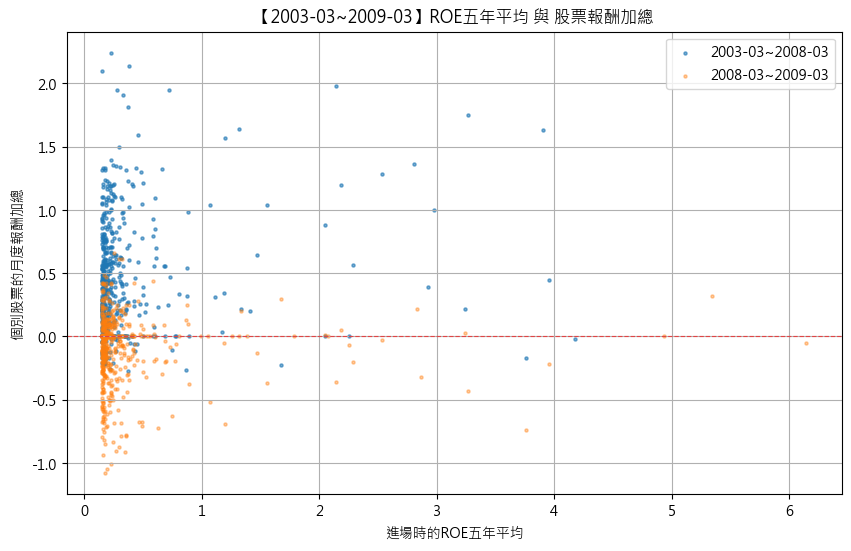

In [110]:
trades_cagr_analysis_split_returns(roe_cond, roe_rol, 'ROE五年平均', N=1, 
                                       split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data, remove=True)

HPQ - value is None or invalid pdays for 2010-02-26 00:00:00
TGTX - value is None or invalid pdays for 2010-05-28 00:00:00
CDW - value is None or invalid pdays for 2013-06-28 00:00:00
CHTR - value is None or invalid pdays for 2010-01-29 00:00:00
LIVN - value is None or invalid pdays for 2015-10-30 00:00:00
UA - value is None or invalid pdays for 2016-01-29 00:00:00
LGF-B - value is None or invalid pdays for 2016-12-30 00:00:00
VC - value is None or invalid pdays for 2010-10-29 00:00:00
CIEN - value is None or invalid pdays for 2021-02-26 00:00:00
AMCR - value is None or invalid pdays for 2019-06-28 00:00:00
ENVA - value is None or invalid pdays for 2014-11-28 00:00:00
GPOR - value is None or invalid pdays for 2021-05-28 00:00:00
移除的極端值 (股票代號, X 值, Y 值):
股票代號: UEC, X 值: 13.234416000000001, Y 值: 0.0
股票代號: COLM, X 值: 0.1502678, Y 值: 0.4985010948739753
股票代號: FFIN, X 值: 0.15030020000000002, Y 值: 0.06019127833253879
股票代號: UEC, X 值: 13.232069599999999, Y 值: 2.513531204478115
股票代號: PVH, X 值: 0

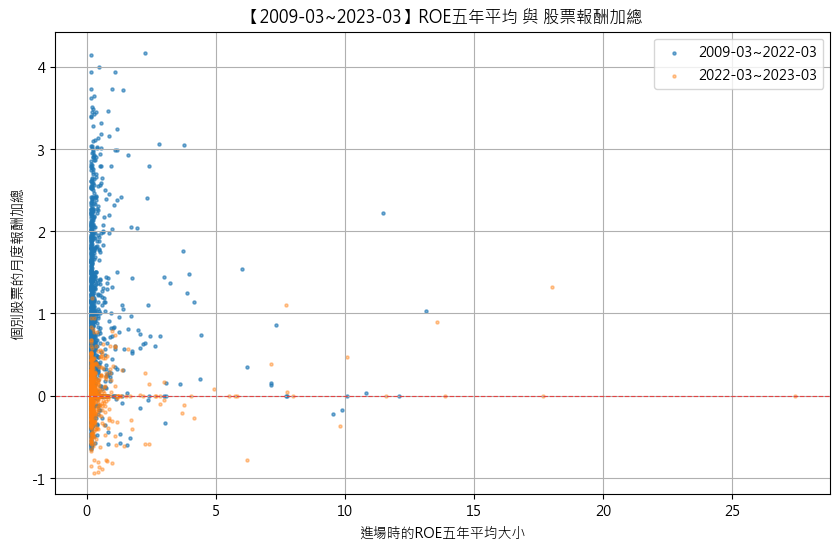

In [95]:
trades_cagr_analysis_split_returns(roe_cond, roe_rol, 'ROE五年平均', N=1, 
                                       split_date='2022-03', start_date='2009-03', end_date='2023-03', data=data, remove=True)

移除的極端值 (股票代號, X 值, Y 值):
股票代號: GIS, X 值: 3.2429812, Y 值: -0.010415541238094628
股票代號: FULT, X 值: 0.1500842, Y 值: 0.24204783901315385
股票代號: MMC, X 值: 0.2155704, Y 值: -0.2744798060849011
股票代號: MO, X 值: 0.481309, Y 值: 1.3021174825455093
移除的極端值 (股票代號, X 值, Y 值):
股票代號: FITB, X 值: 0.1704182, Y 值: -1.449048991571991
股票代號: FNF, X 值: 0.20205060000000002, Y 值: 0.412824077069068
股票代號: CL, X 值: 1.6611392000000003, Y 值: 0.16750901361233006
股票代號: FFIN, X 值: 0.15030020000000002, Y 值: 0.0


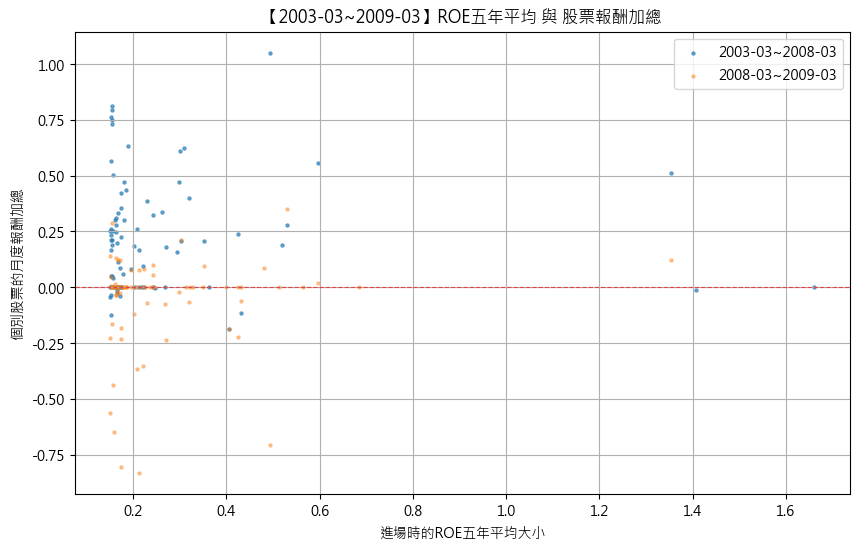

In [107]:
trades_cagr_analysis_split_returns(roe_cond & payout_cond, roe_rol, 'ROE五年平均', N=1, 
                                       split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data, remove=True)

SNPS - value is None or invalid pdays for 2004-02-27 00:00:00
GLDD - value is None or invalid pdays for 2006-12-29 00:00:00
SBUX - value is None or invalid pdays for 2004-02-27 00:00:00
HBI - value is None or invalid pdays for 2006-09-29 00:00:00
HPQ - value is None or invalid pdays for 2004-02-27 00:00:00
ICFI - value is None or invalid pdays for 2006-09-29 00:00:00
SBUX - value is None or invalid pdays for 2009-02-27 00:00:00
WU - value is None or invalid pdays for 2006-09-29 00:00:00


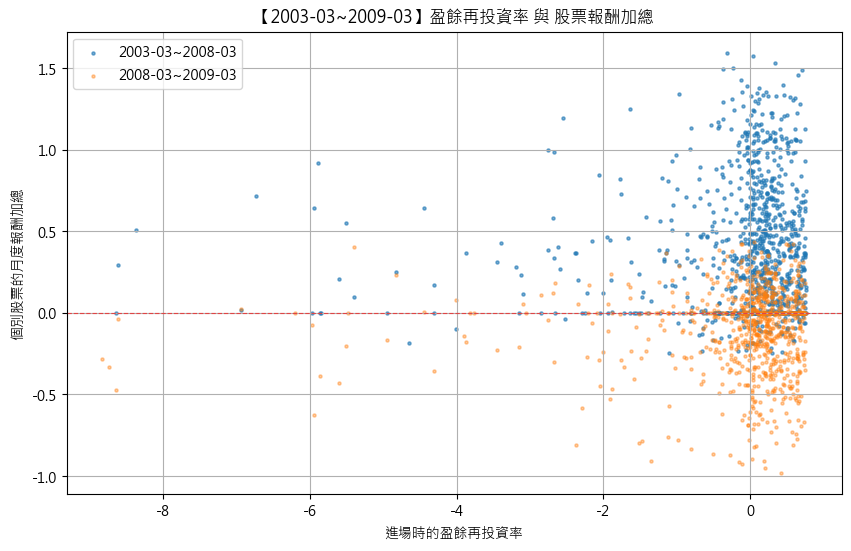

In [111]:
trades_cagr_analysis_split_returns(rr < 0.8, rr, '盈餘再投資率', N=3, 
                                       split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data, remove=True)

NDSN - value is None or invalid pdays for 2004-02-27 00:00:00


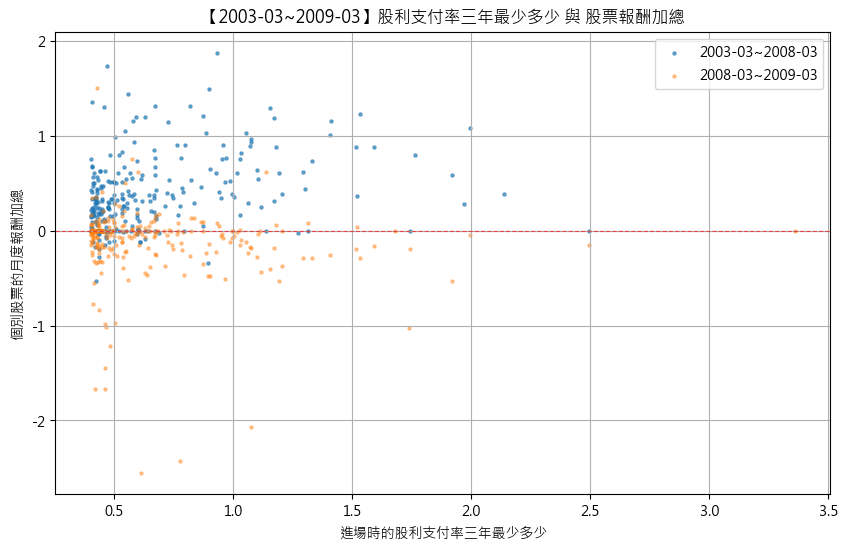

In [112]:
trades_cagr_analysis_split_returns(payout_cond, payout_ratio_rol, '股利支付率三年最少多少', N=1, 
                                       split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data)

ABM - value is None or invalid pdays for 2004-02-27 00:00:00
SNPS - value is None or invalid pdays for 2004-02-27 00:00:00
TTWO - value is None or invalid pdays for 2004-02-27 00:00:00
BX - value is None or invalid pdays for 2007-06-29 00:00:00
EXPE - value is None or invalid pdays for 2005-07-29 00:00:00
GNW - value is None or invalid pdays for 2004-05-28 00:00:00
BR - value is None or invalid pdays for 2007-03-30 00:00:00
DFS - value is None or invalid pdays for 2007-06-29 00:00:00
HBI - value is None or invalid pdays for 2006-09-29 00:00:00
HPQ - value is None or invalid pdays for 2004-02-27 00:00:00
SB - value is None or invalid pdays for 2008-05-30 00:00:00
SWKS - value is None or invalid pdays for 2009-02-27 00:00:00
TTC - value is None or invalid pdays for 2004-02-27 00:00:00
TTWO - value is None or invalid pdays for 2009-02-27 00:00:00
WU - value is None or invalid pdays for 2006-09-29 00:00:00


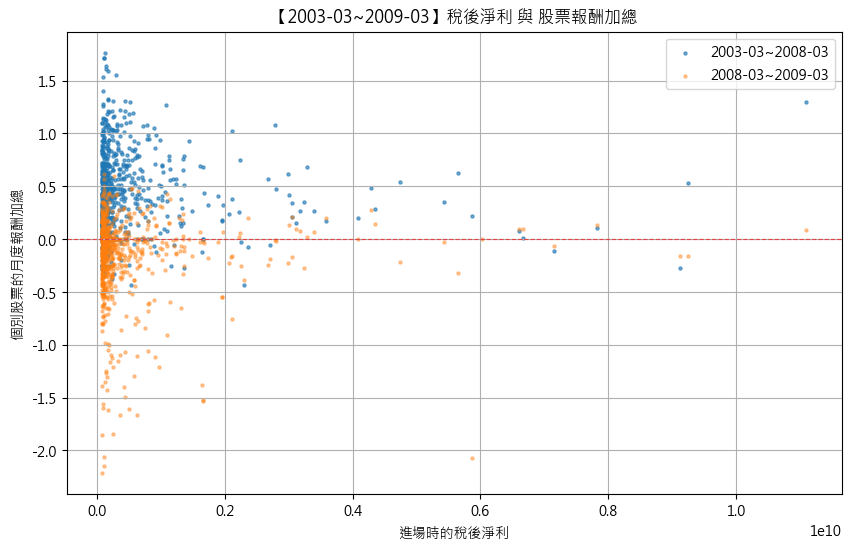

In [113]:
trades_cagr_analysis_split_returns(netprofit_cond, netIncome, '稅後淨利', N=0.5, 
                                       split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data, remove=True)

<Axes: xlabel='date'>

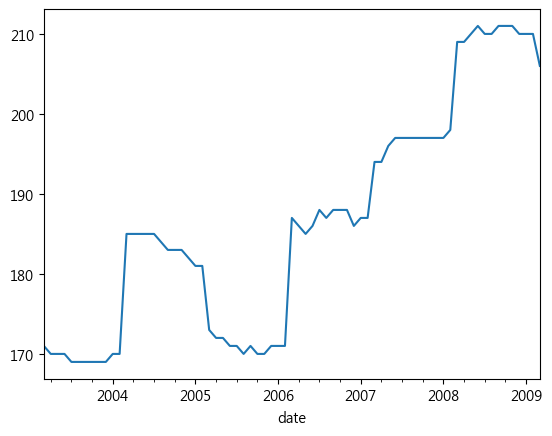

In [104]:
payout_cond['2003-03':'2009-03'].sum(axis=1).plot()

In [70]:
def trades_cagr_analysis(factor_cond, factor, title, N=5, start_date='2003-3', end_date='2009-3', data=data):

    # 進行回測
    rep = backtest.sim(factor_cond[start_date:end_date], resample='M', data=data)
    trades = rep.trades

    # 計算月度回報
    monthly_returns = ((rep.cashflow.resample('M').last() / rep.cashflow.resample('M').first()) - 1).resample('A-MAR').sum()

    # 繪製散佈圖前計算數據
    x_values = []
    y_values = []

    for trade_id, row in trades.iterrows():
        entry_date = row['entry_sig_date']
        exit_date = row['exit_sig_date']

        factor_value = factor[trades['stock_id'][trade_id]][entry_date:entry_date] if entry_date in factor.index else None
        
        if factor_value is not None:  # 確保交易天數和數據有效
            x_values.append(factor_value.values[0])  # 提取因子值
            y_values.append(monthly_returns.loc[entry_date:exit_date, trades['stock_id'][trade_id]].sum())
        else:
            print(f"value is None or invalid pdays for {entry_date}")

    # 將數據轉為 numpy array
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    # 計算 N% 的上下界
    x_lower, x_upper = np.percentile(x_values, [N, 100 - N])
    y_lower, y_upper = np.percentile(y_values, [N, 100 - N])

    # 篩選在上下界內的數據
    valid_indices = np.where((x_values >= x_lower) & (x_values <= x_upper) & 
                             (y_values >= y_lower) & (y_values <= y_upper))[0]
    x_filtered = x_values[valid_indices]
    y_filtered = y_values[valid_indices]

    # 打印被移除的極端值
    removed_x = x_values[np.setdiff1d(np.arange(len(x_values)), valid_indices)]
    removed_y = y_values[np.setdiff1d(np.arange(len(y_values)), valid_indices)]
    print("移除的極端值 (X 值, Y 值):")
    for x, y in zip(removed_x, removed_y):
        print(f"X 值: {x}, Y 值: {y}")

    # 畫圖
    plt.figure(figsize=(10, 6))
    plt.axhline(y=0, color='r', linestyle='--', linewidth=0.85, alpha=0.6)
    plt.scatter(x_filtered, y_filtered, alpha=0.5, s=6)
    plt.title(f"【{start_date}~{end_date}】{title}與股票報酬")
    plt.xlabel(f"進場時的{title}大小")
    plt.ylabel("個別股票的月度報酬加總")
    plt.grid(True)
    plt.show()


value is None or invalid pdays for 2004-02-27 00:00:00
value is None or invalid pdays for 2005-04-29 00:00:00
value is None or invalid pdays for 2006-09-29 00:00:00
value is None or invalid pdays for 2007-03-30 00:00:00
value is None or invalid pdays for 2006-09-29 00:00:00


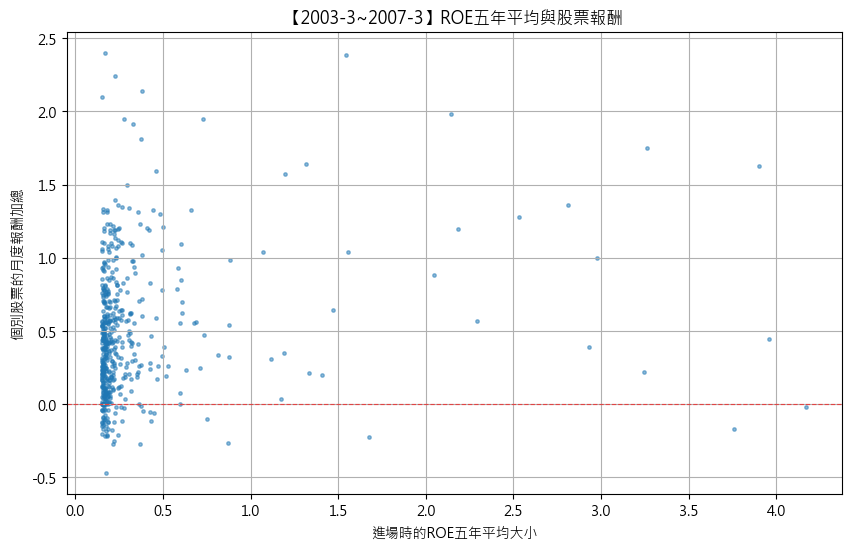

In [ ]:
trades_cagr_analysis(roe_cond, roe_rol, N=5, title='ROE五年平均', start_date='2003-3', end_date='2007-3', data=data)

value is None or invalid pdays for 2007-06-29 00:00:00
value is None or invalid pdays for 2009-02-27 00:00:00
value is None or invalid pdays for 2009-02-27 00:00:00
value is None or invalid pdays for 2009-02-27 00:00:00
value is None or invalid pdays for 2007-06-29 00:00:00
value is None or invalid pdays for 2009-02-27 00:00:00
value is None or invalid pdays for 2009-02-27 00:00:00
移除的極端值 (X 值, Y 值):
X 值: 0.15040939999999997, Y 值: 0.14037021113567605
X 值: 0.17045196, Y 值: 0.7774991117039011
X 值: 0.15035479999999998, Y 值: 0.2505066775635121
X 值: 0.15009319999999998, Y 值: 0.0
X 值: 1.2095776, Y 值: 3.9680348953022566
X 值: 0.18251559999999997, Y 值: -1.6718870687805536
X 值: 0.16235697999999998, Y 值: -2.1588598072101997
X 值: 23.596916200000003, Y 值: -0.7400667075120662
X 值: 20.023350722, Y 值: 0.0
X 值: 2.25252598, Y 值: 1.0681958816982071
X 值: 7.340271960000001, Y 值: 0.0
X 值: 0.41418492, Y 值: -1.7703544416996502
X 值: 0.1927254, Y 值: 0.8951468851184251
X 值: 0.24190680000000003, Y 值: -2.054175944

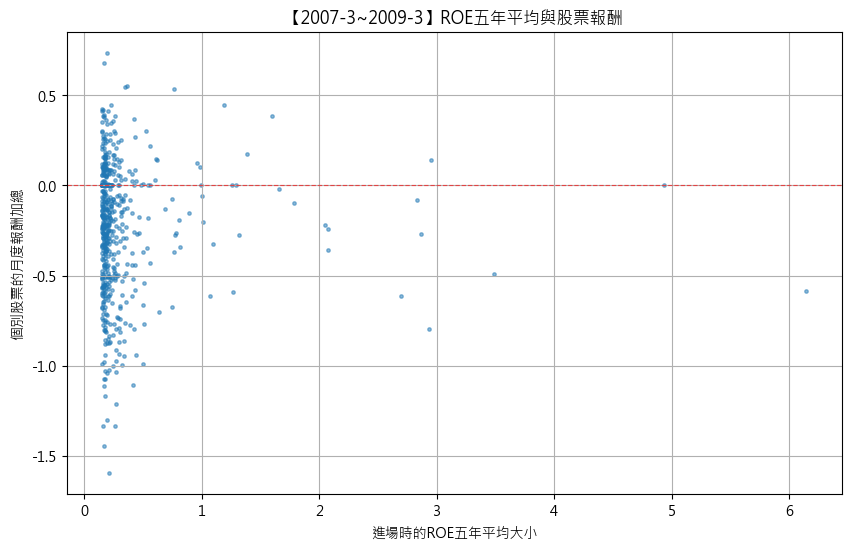

In [66]:
trades_cagr_analysis(roe_cond, roe_rol, N=1, title='ROE五年平均', start_date='2007-3', end_date='2009-3', data=data)

value is None or invalid pdays for 2004-02-27 00:00:00
value is None or invalid pdays for 2004-02-27 00:00:00
value is None or invalid pdays for 2004-02-27 00:00:00
value is None or invalid pdays for 2007-03-30 00:00:00
value is None or invalid pdays for 2005-07-29 00:00:00
value is None or invalid pdays for 2004-05-28 00:00:00
value is None or invalid pdays for 2006-09-29 00:00:00
value is None or invalid pdays for 2004-02-27 00:00:00
value is None or invalid pdays for 2004-02-27 00:00:00
value is None or invalid pdays for 2006-09-29 00:00:00


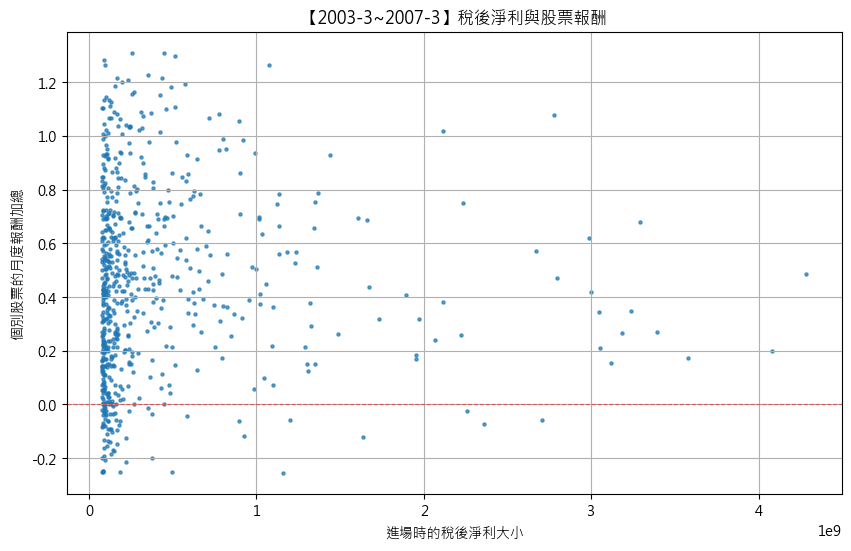

In [ ]:
trades_cagr_analysis(netprofit_cond, netIncome, title='稅後淨利', start_date='2003-3', end_date='2007-3', data=data)

value is None or invalid pdays for 2007-06-29 00:00:00
value is None or invalid pdays for 2007-06-29 00:00:00
value is None or invalid pdays for 2008-05-30 00:00:00
value is None or invalid pdays for 2009-02-27 00:00:00
value is None or invalid pdays for 2009-02-27 00:00:00


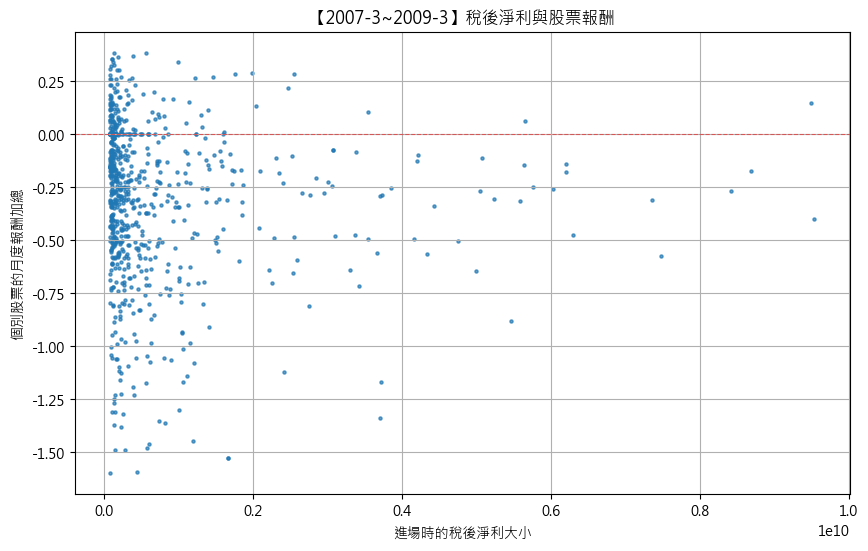

In [ ]:
trades_cagr_analysis(netprofit_cond, netIncome, title='稅後淨利', start_date='2007-3', end_date='2009-3', data=data)

value is None or invalid pdays for 2007-06-29 00:00:00
value is None or invalid pdays for 2007-06-29 00:00:00
value is None or invalid pdays for 2008-05-30 00:00:00
value is None or invalid pdays for 2009-02-27 00:00:00
value is None or invalid pdays for 2009-02-27 00:00:00


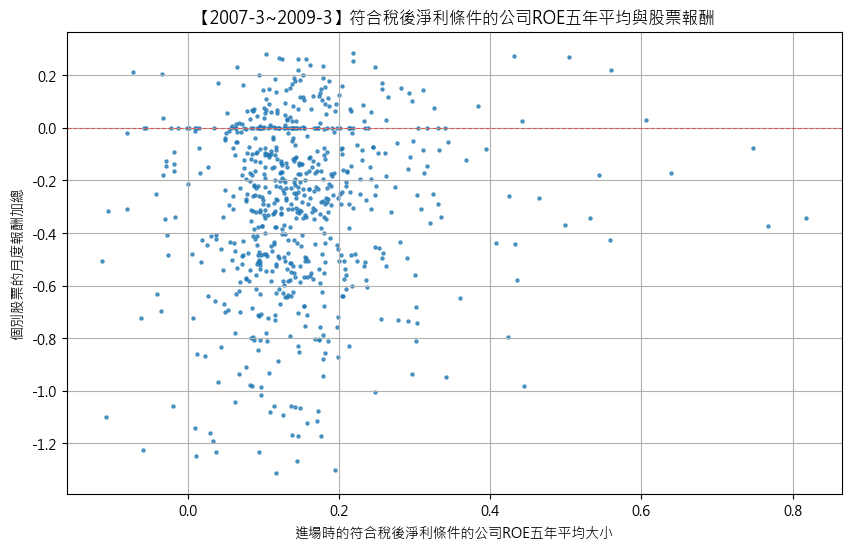

In [ ]:
trades_cagr_analysis(netprofit_cond, roe_rol, N=30, title='符合稅後淨利條件的公司ROE五年平均', start_date='2007-3', end_date='2009-3', data=data)

value is None or invalid pdays for 2004-02-27 00:00:00


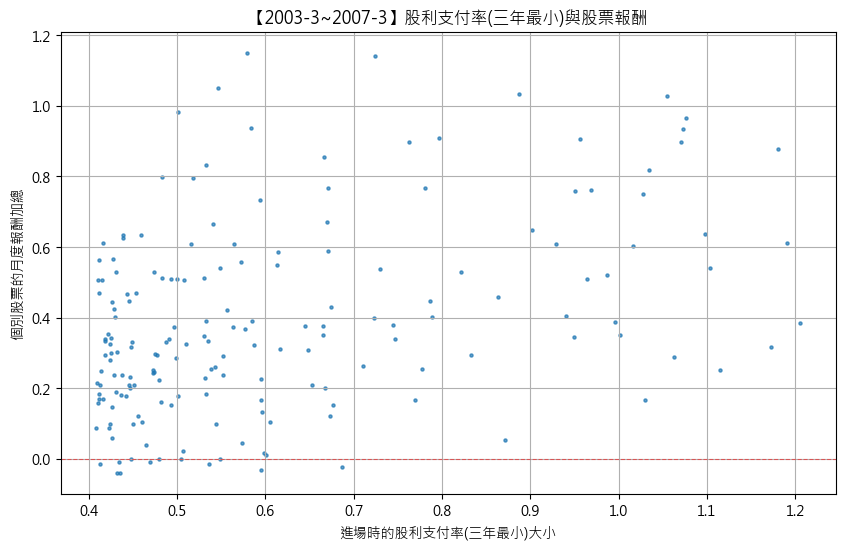

In [ ]:
trades_cagr_analysis(payout_cond, payout_ratio_rol, title='股利支付率(三年最小)', start_date='2003-3', end_date='2007-3', data=data)

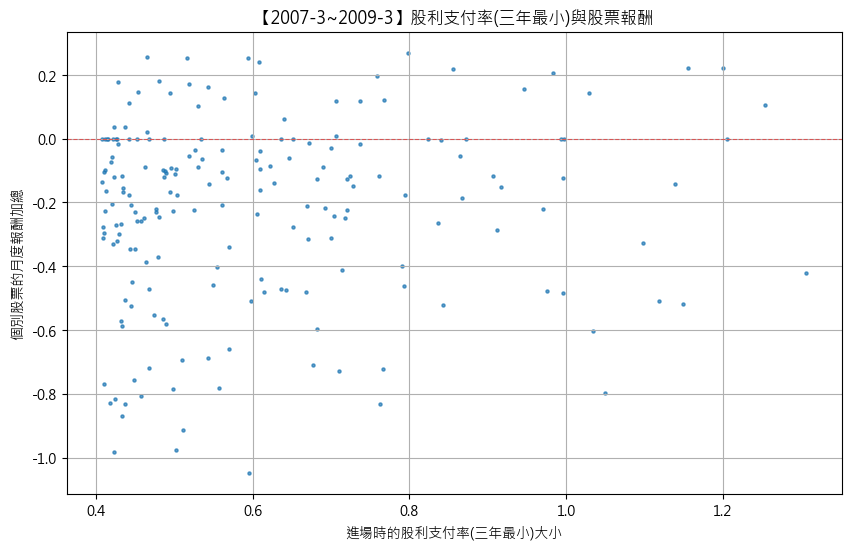

In [ ]:
trades_cagr_analysis(payout_cond, payout_ratio_rol, title='股利支付率(三年最小)', start_date='2007-3', end_date='2009-3', data=data)

value is None or invalid pdays for 2004-02-27 00:00:00


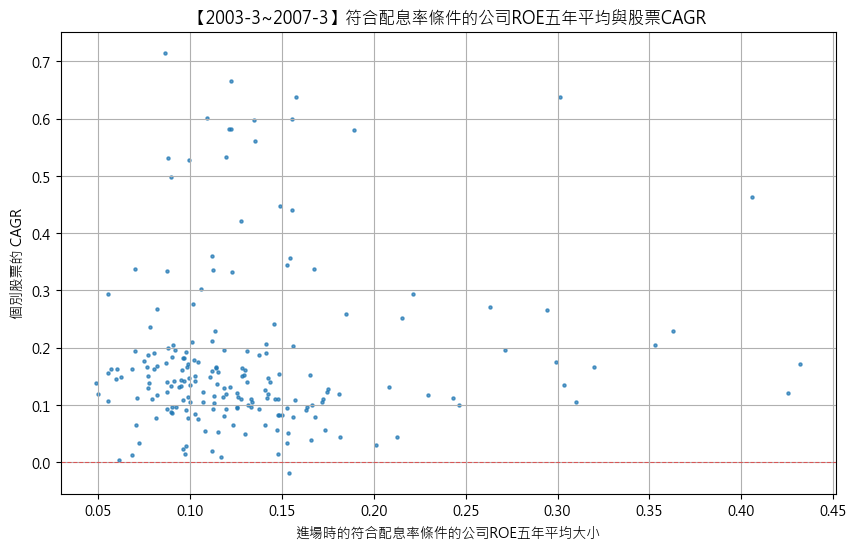

In [ ]:
trades_cagr_analysis(payout_cond, roe_rol, N=10, title='符合配息率條件的公司ROE五年平均', start_date='2003-3', end_date='2007-3', data=data)

value is None or invalid pdays for 2007-04-30 00:00:00


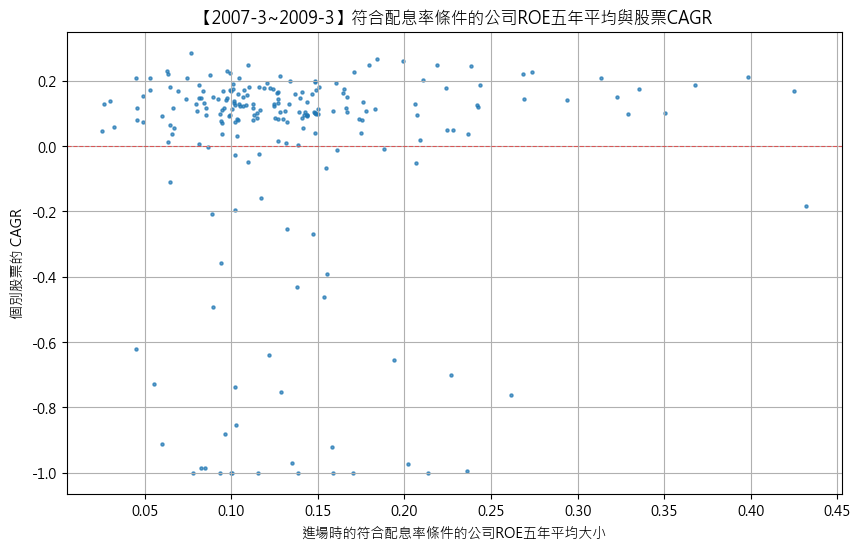

In [ ]:
trades_cagr_analysis(payout_cond, roe_rol, N=10, title='符合配息率條件的公司ROE五年平均', start_date='2007-3', end_date='2009-3', data=data)

value is None or invalid pdays for 2007-04-30 00:00:00


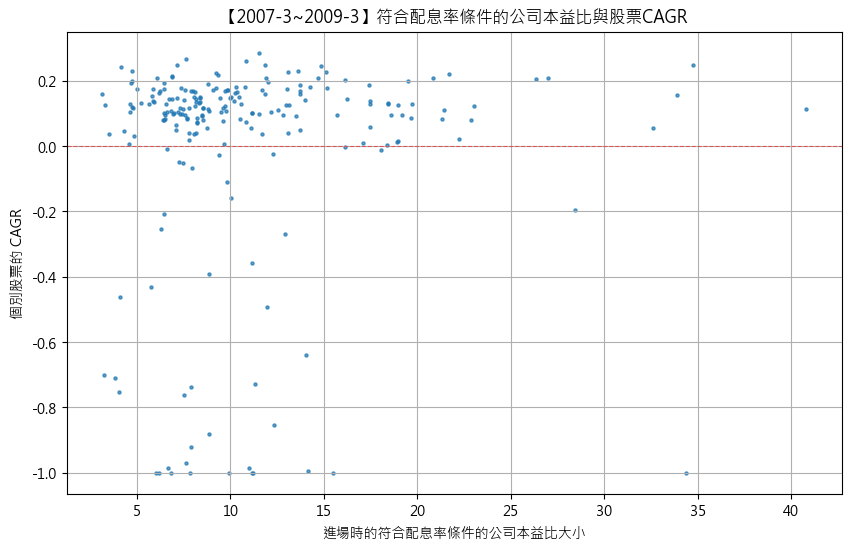

In [ ]:
trades_cagr_analysis(payout_cond, pe_daily.resample('M').last(), N=10, title='符合配息率條件的公司本益比', start_date='2007-3', end_date='2009-3', data=data)

value is None or invalid pdays for 2007-04-30 00:00:00


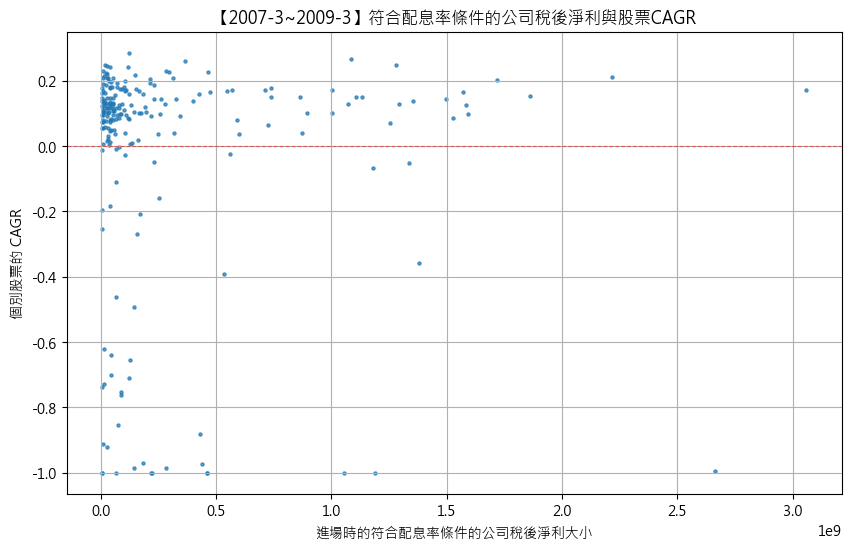

In [ ]:
trades_cagr_analysis(payout_cond, netIncome, N=10, title='符合配息率條件的公司稅後淨利', start_date='2007-3', end_date='2009-3', data=data)

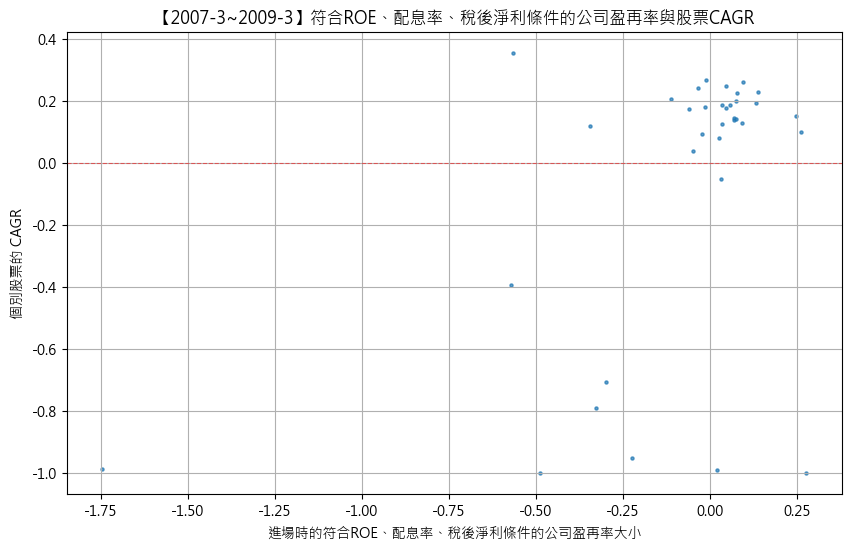

In [ ]:
trades_cagr_analysis(roe_cond & payout_cond & netprofit_cond & listed_cond & rr_cond, rr, N=1, title='符合ROE、配息率、稅後淨利條件的公司盈再率', start_date='2007-3', end_date='2009-3', data=data)

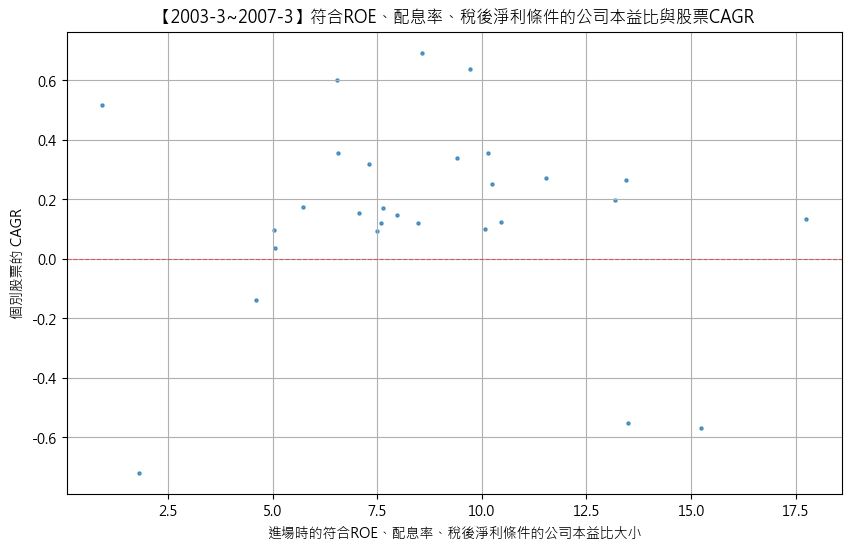

In [ ]:
trades_cagr_analysis(roe_cond & payout_cond & netprofit_cond & listed_cond & rr_cond, pe_daily, N=1, title='符合ROE、配息率、稅後淨利條件的公司本益比', start_date='2003-3', end_date='2007-3', data=data)

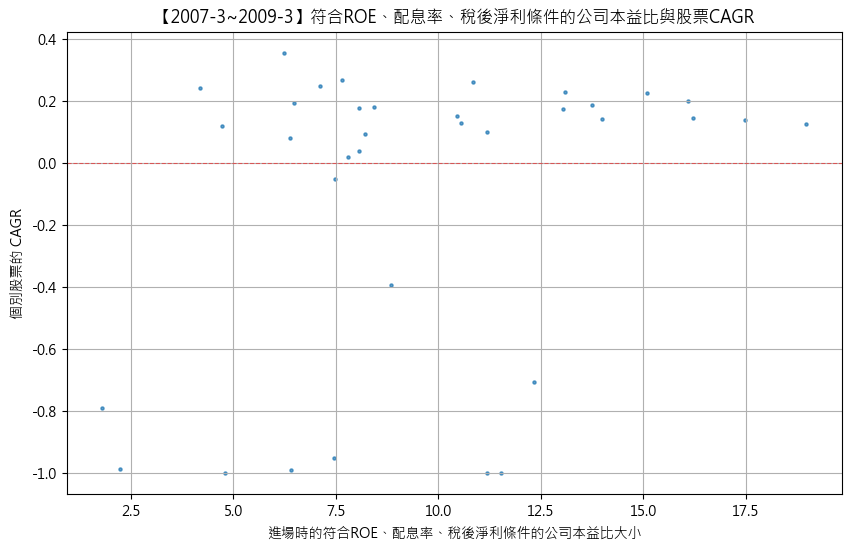

In [ ]:
trades_cagr_analysis(roe_cond & payout_cond & netprofit_cond & listed_cond & rr_cond, pe_daily, N=1, title='符合ROE、配息率、稅後淨利條件的公司本益比', start_date='2007-3', end_date='2009-3', data=data)

In [ ]:
# backtest.sim(payout_cond['2003-3':'2007-3'], resample='M', data=data).display()

,annualized_rate_of_return,sharpe,max_drawdown,win_ratio
,19.42%,89.02,-9.49%,92.86%


,entry_date,exit_date,entry_sig_date,exit_sig_date,position,period,entry_index,exit_index,return,mae,gmfe,bmfe,mdd,pdays,weight,next_weights
stock_id,,,,,,,,,,,,,,,,
EMR,2003-04-01,2007-02-01,2003-03-31,2007-01-31,0.005882,966,814,1780,1.159425,0.000000,1.169425,0.000000,-0.162597,966.0,0.000000,0.000000
IMKTA,2003-04-01,2007-02-01,2003-03-31,2007-01-31,0.005882,966,814,1780,3.945598,-0.015444,3.955598,0.027027,-0.141176,956.0,0.000000,0.000000
ABCB,2004-04-01,NaT,2004-03-31,NaT,0.005525,5167,1067,-1,4.194467,-0.734536,4.582474,0.985395,-0.866292,3923.0,0.005464,0.005464
ABR,2006-04-03,NaT,2006-03-31,NaT,0.005464,4663,1571,-1,1.565503,-0.969017,1.627517,0.382550,-0.977590,1677.0,0.005464,0.005464
ABT,2003-04-01,NaT,2003-03-31,NaT,0.005882,5420,814,-1,9.897547,-0.016038,11.675472,0.201887,-0.338791,5418.0,0.005464,0.005464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WPC,2004-04-01,NaT,2004-03-31,NaT,0.005525,5167,1067,-1,5.936136,-0.248244,7.932084,0.466042,-0.524494,4697.0,0.005464,0.005464
WSBC,2003-04-01,NaT,2003-03-31,NaT,0.005882,5420,814,-1,1.699797,-0.336414,2.621072,0.628466,-0.616386,5002.0,0.005464,0.005464
WTRG,2003-04-01,NaT,2003-03-31,NaT,0.005882,5420,814,-1,5.151859,-0.025641,6.955128,0.009615,-0.479294,5405.0,0.005464,0.005464


In [ ]:
backtest.sim(rr_cond['2003-3':'2007-3'], resample='M', data=data).display()

,annualized_rate_of_return,sharpe,max_drawdown,win_ratio
,27.13%,70.52,-10.61%,83.78%


,entry_date,exit_date,entry_sig_date,exit_sig_date,position,period,entry_index,exit_index,return,mae,gmfe,bmfe,mdd,pdays,weight,next_weights
stock_id,,,,,,,,,,,,,,,,
A,2007-02-01,NaT,2007-01-31,NaT,0.001704,4454,1780,-1,5.912405,-0.613482,7.510184,0.255092,-0.692040,3903.0,0.001701,0.001701
AAON,2003-04-01,NaT,2003-03-31,NaT,0.002451,5420,814,-1,73.879655,-0.062069,74.503448,0.006897,-0.435567,5408.0,0.001701,0.001701
AAP,2006-04-03,NaT,2006-03-31,NaT,0.001745,4663,1571,-1,0.017378,-0.409015,5.245852,0.089049,-0.836529,3878.0,0.001701,0.001701
AAPL,2003-04-01,NaT,2003-03-31,NaT,0.002451,5420,814,-1,1071.626164,-0.073432,1097.440500,0.031096,-0.608624,5407.0,0.001701,0.001701
ABG,2006-04-03,NaT,2006-03-31,NaT,0.001745,4663,1571,-1,11.758076,-0.884884,14.495746,0.590786,-0.927636,3792.0,0.001701,0.001701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,2003-04-01,NaT,2003-03-31,NaT,0.002451,5420,814,-1,21.388319,-0.023529,22.828571,0.047059,-0.521671,5418.0,0.001701,0.001701
ZBH,2005-04-01,NaT,2005-03-31,NaT,0.001934,4916,1318,-1,0.569902,-0.569760,1.590811,0.230332,-0.650306,3338.0,0.001701,0.001701
ZBRA,2003-04-01,NaT,2003-03-31,NaT,0.002451,5420,814,-1,11.775319,-0.430402,20.279432,1.143006,-0.734206,4981.0,0.001701,0.001701


## ROE

In [ ]:
# roe_rol['2003':].to_csv('./performance_file/US/roe五年平均_2003-2009.csv')

In [ ]:
# roe_Q = data.get('quarter_report:ROE')

In [ ]:
# roe_test = roe_Q['2000-3':'2022-3'].divide_slice(5, ascending=False)
# roe_test = roe['2003-3':'2009-3'].divide_slice(5, ascending=False)

In [ ]:
# roe_combs_test = sim_conditions(roe_test, resample='M', data=data)
# roe_combs_test.selected_stock_count_analysis()
roe_test = roe_rol['2003-3':'2007-3'].notna()
roe_combs_test = backtest.sim(roe_test, resample='M', data=data)
roe_combs_test.display()

,annualized_rate_of_return,sharpe,max_drawdown,win_ratio
,31.81%,62.76,-10.49%,0%


,entry_date,exit_date,entry_sig_date,exit_sig_date,position,period,entry_index,exit_index,return,mae,gmfe,bmfe,mdd,pdays,weight,next_weights
stock_id,,,,,,,,,,,,,,,,
A,2003-04-01,NaT,2003-03-31,NaT,0.000866,5420,814,-1,16.504110,-0.022086,20.531288,2.175460,-0.692040,5414.0,0.000726,0.000726
AAL,2005-10-03,NaT,2005-09-30,NaT,0.000774,4788,1446,-1,-0.429801,-0.918140,1.927914,1.927914,-0.972041,2265.0,0.000726,0.000726
AAON,2003-04-01,NaT,2003-03-31,NaT,0.000866,5420,814,-1,73.879655,-0.062069,74.503448,0.006897,-0.435567,5408.0,0.000726,0.000726
AAP,2003-04-01,NaT,2003-03-31,NaT,0.000866,5420,814,-1,1.776947,0.000000,15.942986,0.000000,-0.836529,5419.0,0.000726,0.000726
AAPL,2003-04-01,NaT,2003-03-31,NaT,0.000866,5420,814,-1,1071.626164,-0.073432,1097.440500,0.031096,-0.608624,5407.0,0.000726,0.000726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZD,2003-04-01,NaT,2003-03-31,NaT,0.000866,5420,814,-1,7.173878,-0.087838,23.835510,0.214529,-0.701910,5404.0,0.000726,0.000726
ZEUS,2003-04-01,NaT,2003-03-31,NaT,0.000866,5420,814,-1,11.653430,-0.045307,22.152104,0.100324,-0.888150,5406.0,0.000726,0.000726
ZION,2003-04-01,NaT,2003-03-31,NaT,0.000866,5420,814,-1,0.660820,-0.827276,1.316372,1.213569,-0.921970,3097.0,0.000726,0.000726


In [ ]:
roe_combs_test.cashflow #.to_csv('./performance_file/US/roe五年平均_2003-2009_每年resample_cash.csv')

In [ ]:
# roe_combs_test.plot_creturns()

In [ ]:
# _,_=roe_combs_test.reports['Quantile_5'].calc_returns_contrib(5)

In [ ]:
# roe_combs_test.plot_creturns()

In [ ]:
# close[['VNDA']]['2003':'2012'].plot()

In [ ]:
# (roe_rol['2003-3':'2004-3'].notna()).sum(axis=1)

In [ ]:
# roe_returns_df = roe_combs_test.cashflow.drop('cash', axis=1)

---

In [ ]:
# close['2003':'2009'].resample('A-MAR').last()

In [ ]:
# monthly_last = close.resample('A-MAR').last()
# # monthly_first = close.resample('A-MAR').first()

# # 計算每月報酬率
# monthly_returns = (monthly_last / monthly_last.shift(1)) - 1
# # monthly_returns_df = monthly_returns.resample('A-MAR').sum().iloc[1:]

In [ ]:
# monthly_returns['2003':'2009']

In [ ]:
# roe_rol.resample('A-MAR').last()['2002':'2007']

In [ ]:
# # 選取 '2003' 到 '2009' 的數據
# roe_rol_filtered = roe_rol.loc['2003':'2024']
# close_filtered = close.loc['2003':'2024']

# # # 確保數據是數值型態
# # roe_rol_filtered['AAPL'] = roe_rol_filtered['AAPL'].astype(float)
# # close_filtered['AAPL'] = close_filtered['AAPL'].astype(float)

# # 創建圖表
# fig, ax1 = plt.subplots(figsize=(10, 6))

# # 繪製第一條折線（ROE Rolling）在左側 Y 軸
# ax1.plot(roe_rol_filtered.index, roe_rol_filtered['TSLA'], label='ROE Rolling (AAPL)', color='blue', linewidth=2)
# ax1.set_xlabel('Date', fontsize=12)
# ax1.set_ylabel('ROE Rolling (AAPL)', fontsize=12, color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# # 創建第二個 Y 軸（右側），並繪製第二條折線（Close Price）
# ax2 = ax1.twinx()
# ax2.plot(close_filtered.index, close_filtered['TSLA'], label='Close Price (AAPL)', color='green', linewidth=2)
# ax2.set_ylabel('Close Price (AAPL)', fontsize=12, color='green')
# ax2.tick_params(axis='y', labelcolor='green')

# # 添加圖例
# fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.95), fontsize=10)

# # 添加標題
# plt.title('AAPL: ROE Rolling vs Close Price (2003-2009)', fontsize=16)
# plt.tight_layout()

# # 顯示圖表
# plt.show()

---

In [ ]:
# def price_returns_test(factor, START_DATE='2003-3', END_DATE='2007-3', exclude_n=150, title="ROE", ratio=True):
#     monthly_last = close.resample('A-MAR').last()
#     monthly_returns = (monthly_last / monthly_last.shift(1)) - 1

#     # 確保 factor 和 monthly_returns 有相同的columns
#     common_columns = factor.columns.intersection(monthly_returns.columns)
#     factor_adj_df = factor[START_DATE:END_DATE][common_columns].resample('A-MAR').last()
#     factor_adj_df.index = factor_adj_df.index + pd.DateOffset(years=1)

#     # 整理數據
#     combined_df = pd.concat([factor_adj_df.stack(), monthly_returns[common_columns].stack()], axis=1, keys=['Factor', 'Return'])
#     combined_df = combined_df.dropna()  # 移除NaN值

#     # 排序並去除最大與最小N筆資料
#     X_sorted_indices = combined_df.sort_values(by='Factor').iloc[exclude_n:-exclude_n].index
#     Y_sorted_indices = combined_df.sort_values(by='Return').iloc[exclude_n:-exclude_n].index
#     filtered_indices = X_sorted_indices.intersection(Y_sorted_indices)
#     combined_df = combined_df.loc[filtered_indices]

#     # print 出排除的column名稱與數值
#     excluded_factor = pd.concat([combined_df.sort_values(by='Factor').iloc[:exclude_n], combined_df.sort_values(by='Factor').iloc[-exclude_n:]])
#     excluded_return = pd.concat([combined_df.sort_values(by='Return').iloc[:exclude_n], combined_df.sort_values(by='Return').iloc[-exclude_n:]])
#     print("Excluded factor values:")
#     print(excluded_factor['Factor'])
#     print("\nExcluded Return values:")
#     print(excluded_return['Return'])

#     # 繪製散點圖
#     plt.figure(figsize=(14, 6))
#     plt.axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
#     plt.scatter(combined_df['Factor'], combined_df['Return'], alpha=0.7, s=3)
#     plt.title(f'{START_DATE} ~ {END_DATE} {title}與報酬率')
#     plt.xlabel(f'{title}')
#     plt.ylabel('股價一年變化 (%)')

#     plt.grid(True, linestyle='--', alpha=0.5)

#     # 設定X與Y軸為百分比單位，每個ticks之間間隔0.10
#     if ratio:
#         plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
#         plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
#         plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.10))
#         plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.25))

#     plt.show()

In [ ]:
# price_returns_test(roe, START_DATE='2003-3', END_DATE='2004-3', exclude_n=50, title="ROE", ratio=False)

In [ ]:
# price_returns_test(roe_rol, START_DATE='2022-3', END_DATE='2023-3', exclude_n=25, title="ROE五年平均", ratio=False)

In [ ]:
# price_returns_test(netIncome, START_DATE='2007-3', END_DATE='2009-3', exclude_n=100, title="稅後淨利", ratio=False)

In [ ]:
# def factor_returns_test(factor, START_DATE='2003-3', END_DATE='2007-3', exclude_n=150, title="ROE", ratio=True, data=data):

#     position = factor[START_DATE:END_DATE].notna()
#     rep = backtest.sim(position, resample='M', data=data)

#     cash_df = rep.cashflow.drop('cash', axis=1)

#     monthly_last = cash_df.resample('M').last()
#     monthly_first = cash_df.resample('M').first()

#     # 計算每月報酬率
#     monthly_returns = (monthly_last / monthly_first) - 1
#     monthly_returns_df = monthly_returns.resample('A-MAR').sum().iloc[1:]

#     factor_adj_df = factor[START_DATE:END_DATE][monthly_returns_df.columns].resample('A-MAR').last()
#     factor_adj_df.index = factor_adj_df.index + pd.DateOffset(years=1)


#     # 整理數據
#     combined_df = pd.concat([factor_adj_df.stack(), monthly_returns_df.stack()], axis=1, keys=['Factor', 'Return'])
#     combined_df = combined_df.dropna()  # 移除NaN值

#     # 排序並去除最大與最小N筆資料
#     # exclude_n = 150

#     # 分別對ROE和Return排序後的索引取交集，確保同時剔除兩者極端值
#     X_sorted_indices = combined_df.sort_values(by='Factor').iloc[exclude_n:-exclude_n].index
#     Y_sorted_indices = combined_df.sort_values(by='Return').iloc[exclude_n:-exclude_n].index
#     filtered_indices = X_sorted_indices.intersection(Y_sorted_indices)
#     combined_df = combined_df.loc[filtered_indices]

#     # print 出排除的column名稱與數值
#     excluded_factor = pd.concat([combined_df.sort_values(by='Factor').iloc[:exclude_n], combined_df.sort_values(by='Factor').iloc[-exclude_n:]])
#     excluded_return = pd.concat([combined_df.sort_values(by='Return').iloc[:exclude_n], combined_df.sort_values(by='Return').iloc[-exclude_n:]])
#     print("Excluded factor values:")
#     print(excluded_factor['Factor'])
#     print("\nExcluded Return values:")
#     print(excluded_return['Return'])

#     # 繪製散點圖
#     plt.figure(figsize=(14, 6))
#     plt.axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
#     plt.scatter(combined_df['Factor'], combined_df['Return'], alpha=0.7, s=3)
#     plt.title(f'{START_DATE} ~ {END_DATE} {title}與報酬率加總')
#     plt.xlabel(f'{title}')
#     plt.ylabel('報酬率加總 (%)')

#     plt.grid(True, linestyle='--', alpha=0.5)

#     # 設定X與Y軸為百分比單位，每個ticks之間間隔0.10
#     if ratio:
        
#         plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
#         plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
#         plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.10))
#         plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.25))

#     plt.show()

In [ ]:
# factor_returns_test(roe, START_DATE='2003-3', END_DATE='2004-3', exclude_n=5, title="ROE", ratio=False, data=data)

In [ ]:
# factor_returns_test(roe, START_DATE='2007-3', END_DATE='2009-3', exclude_n=75, title="ROE", ratio=True, data=data)

In [ ]:
# factor_returns_test(roe, START_DATE='2009-3', END_DATE='2024-3', exclude_n=500, title="ROE", ratio=True, data=data)

In [ ]:
# factor_returns_test(roe, START_DATE='2022-3', END_DATE='2023-3', exclude_n=30, title="ROE", ratio=True, data=data)

In [ ]:
# factor_returns_test(roe_rol, START_DATE='2003-3', END_DATE='2007-3', exclude_n=150, title="ROE五年平均", ratio=True, data=data)

In [ ]:
# factor_returns_test(roe_rol, START_DATE='2007-3', END_DATE='2009-3', exclude_n=10, title="ROE五年平均", ratio=True, data=data)

In [ ]:
# factor_returns_test(netIncome, START_DATE='2003-3', END_DATE='2007-3', exclude_n=550, title="稅後淨利", ratio=False, data=data)

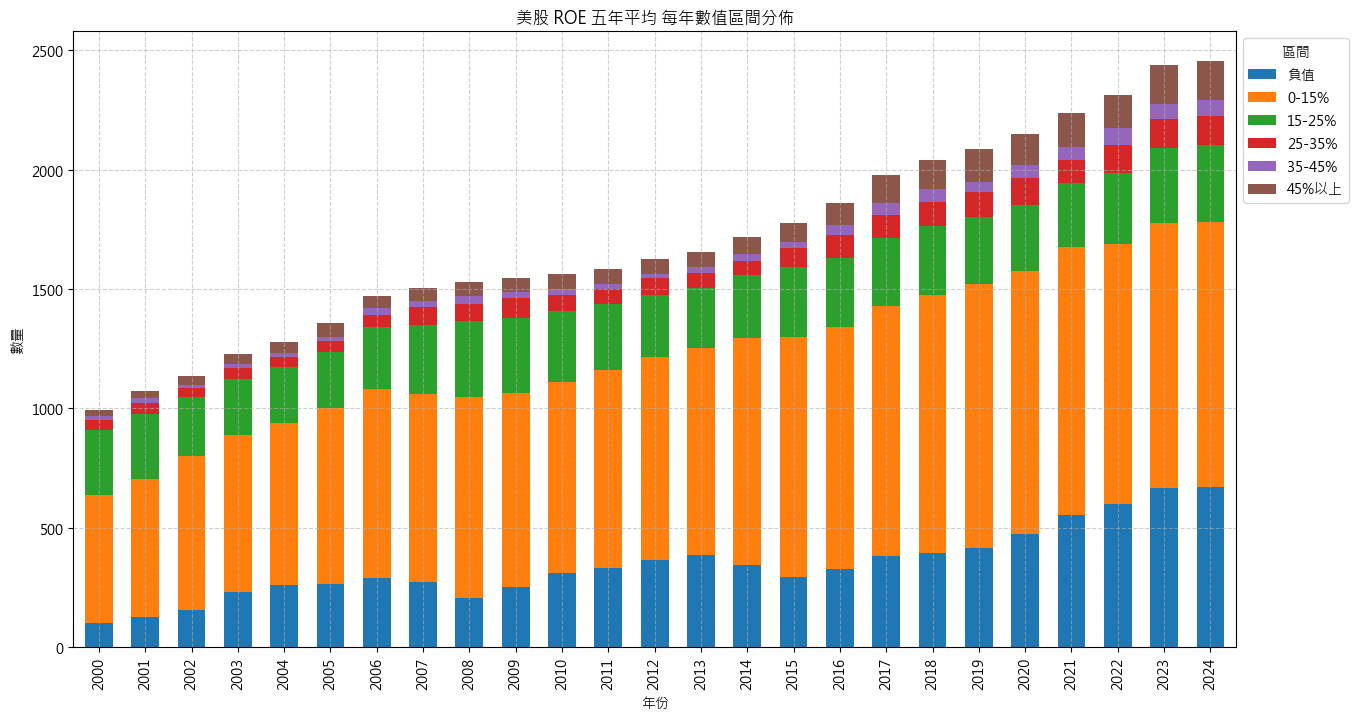

In [ ]:
plot_data.numeric_bins(roe_rol['2000':'2023'].resample('A-MAR').last(), title='美股 ROE 五年平均', bins=[-np.inf, 0, 0.15, 0.25, 0.35, 0.45, np.inf], 
    labels=['負值' ,'0-15%', '15-25%', '25-35%', '35-45%','45%以上'], num_label=False)

---

In [ ]:
# roe_combs_test.selected_stock_count_analysis()

In [ ]:
# _,_=roe_combs_test.calc_returns_contrib()

In [ ]:
# roe_combs_test_df = roe_combs_test.selected_stock_count_analysis()

In [ ]:
# # 提取數字N並轉換為數字型別
# roe_combs_test_df['Quantile_N'] = roe_combs_test_df.index.to_series().str.extract(r'Quantile_(\d+)')[0].astype(int)

# # 設定要去除的前 N 大數量
# N = 0

# # 按照 'CAGR (%)' 排序，剔除前 N 大的資料
# filtered_df = roe_combs_test_df.sort_values(by='CAGR (%)', ascending=False).iloc[N:]

# # 繪製 scatter plot
# plt.figure(figsize=(15, 6))
# plt.scatter(filtered_df['Quantile_N'], filtered_df['CAGR (%)'], alpha=0.8, s=10)
# plt.axhline(y=0, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
# plt.xlabel('N (Quantile Number)')
# plt.ylabel('CAGR (%)')
# plt.title(f'Scatter Plot of CAGR (%) vs. Quantile N (Excluding Top {N} Y-Axis Values)')
# plt.grid(True)
# plt.show()
